In [3]:
#the traces used here are from sasebo g2 hence the model will be hamming distance model
using MAT
using DataFrames
using PyPlot
plt = PyPlot

PyPlot

In [4]:
#The following is the way to load the traces in the tool
#=
pctracedf = readtable("../AES_sasebo_g2_traces/trace10000.csv");
#to replace any existing NA's with zeros
c = length(AES[1,:])
for i in 1:c
    pctracedf[isna(pctrace[i]),i] = 0.0;
end
ptexts = pctracedf[1];
ctexts = pctracedf[2];
traces = pctracedf[:,3:end];
=#

In [5]:
#for the purpose of this demo reading from a mat file
ctrace = matopen("../traces_aes.mat")
ctexts_ = read(ctrace,"ctext");
traces = read(ctrace,"traces");

In [6]:
#utility functions
function transformToMatrix(IV)
    matrixIV = zeros(UInt8,4,4)
    l = length(IV)
    for i in 2:2:l
        k = div(i,2)
        valstr = IV[i-1:i]
        val = parse(UInt8,valstr,16)
        if k%4 == 0
            r = 4
        else
            r = k%4
        end
        c = trunc(Int8,ceil(k/4))
        matrixIV[r,c] = val
    end
    matrixIV
end

transformToMatrix (generic function with 1 method)

In [7]:
#method to convert the ciphertext in the required format
ctexts = Array(String,length(ctexts_[:,1]))
for i in 1:length(ctexts_[:,1])
    str = ""
    for j in ctexts_[i,:]
        str = join([str,hex(j,2)])
    end
    ctexts[i] = str
end

In [9]:
#checking the execution time for conversion of a single ciphertext
i=7
println(ctexts[i])
@time transformToMatrix(ctexts[i])

dcb20e08836f72db93d767b58f59384b
  0.000014 seconds (37 allocations: 2.016 KB)


4×4 Array{UInt8,2}:
 0xdc  0x83  0x93  0x8f
 0xb2  0x6f  0xd7  0x59
 0x0e  0x72  0x67  0x38
 0x08  0xdb  0xb5  0x4b

In [10]:
#=
#the following function is to apply the inverse of shift row operation on the matrix
function invShiftRows(matrixIV)
    invMat = zeros(UInt8,4,4)
    for i in 1:4
        for j in 1:4
            invMat[i,(((j-1)+(i-1))%4)+1] = matrixIV[i,j] #(i,(((j-1)+(i-1))%4)+1) is the index in the original matrix 
            end                                           #of the cell which is at (i,j) in the given matrix after shiftrow
    end
    invMat
end
=#
function invShiftRows(i,j)
    #invMat = zeros(UInt8,4,4)
    #for i in 1:4
    #    for j in 1:4
    #        invMat[i,(((j-1)+(i-1))%4)+1] = matrixIV[i,j] #(i,(((j-1)+(i-1))%4)+1) is the index in the original matrix
    #        end                                           #of the cell which is at (i,j) in the given matrix after shiftrow
    #end
    #invMat
    i,(((j-1)+(i-1))%4)+1
end

function invSlayer(matrixstate)
    mat = zeros(UInt8,4,4)
    for j in 1:4
        for i in 1:4
            mat[i,j] = invSbox[matrixstate[i,j]+1]
        end
    end
    mat
end

function hw_look_up_maker(binstr)
    hw = 0
    for i in 1:length(binstr)
        if binstr[i] == '1'
            hw = hw+1
        end
    end
    hw
end
HW8 = Dict()
for i in 0:255
    HW8[i] = hw_look_up_maker(bin(i,8))
end


#=
#calculate the original hamming distance between the last round input and the output
#so i know the cipher text and the last round key
function get_last_key()
    last_key_ = [208, 20, 249, 168, 201, 238, 37, 137, 225, 63, 12, 200, 182, 99, 12, 166]
    l_key = ""
    for i in last_key_
        l_key = join([l_key,bin(i,8)])
    end
    
    #formatting the key as we need it
    lk = zeros(Int,4)
    for j in 32:32:128
        lk[div(j,32)]= parse(Int,l_key[j-31:j],2)
    end
    transformToMatrix(lk)
end

#now to get the input of the last round
function get_input_last_round(matrixCT, matrixLK)
    matxor = matrixCT$matrixLK
    matinvSR = invShiftRows(matxor)
    matinvS = invSlayer(matinvSR)
    
    matinvS
end
=#

In [11]:
invS_box = [
0x52, 0x09, 0x6a, 0xd5, 0x30, 0x36, 0xa5, 0x38, 0xbf, 0x40, 0xa3, 0x9e, 0x81, 0xf3, 0xd7, 0xfb,
0x7c, 0xe3, 0x39, 0x82, 0x9b, 0x2f, 0xff, 0x87, 0x34, 0x8e, 0x43, 0x44, 0xc4, 0xde, 0xe9, 0xcb,
0x54, 0x7b, 0x94, 0x32, 0xa6, 0xc2, 0x23, 0x3d, 0xee, 0x4c, 0x95, 0x0b, 0x42, 0xfa, 0xc3, 0x4e,
0x08, 0x2e, 0xa1, 0x66, 0x28, 0xd9, 0x24, 0xb2, 0x76, 0x5b, 0xa2, 0x49, 0x6d, 0x8b, 0xd1, 0x25,
0x72, 0xf8, 0xf6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xd4, 0xa4, 0x5c, 0xcc, 0x5d, 0x65, 0xb6, 0x92,
0x6c, 0x70, 0x48, 0x50, 0xfd, 0xed, 0xb9, 0xda, 0x5e, 0x15, 0x46, 0x57, 0xa7, 0x8d, 0x9d, 0x84,
0x90, 0xd8, 0xab, 0x00, 0x8c, 0xbc, 0xd3, 0x0a, 0xf7, 0xe4, 0x58, 0x05, 0xb8, 0xb3, 0x45, 0x06,
0xd0, 0x2c, 0x1e, 0x8f, 0xca, 0x3f, 0x0f, 0x02, 0xc1, 0xaf, 0xbd, 0x03, 0x01, 0x13, 0x8a, 0x6b,
0x3a, 0x91, 0x11, 0x41, 0x4f, 0x67, 0xdc, 0xea, 0x97, 0xf2, 0xcf, 0xce, 0xf0, 0xb4, 0xe6, 0x73,
0x96, 0xac, 0x74, 0x22, 0xe7, 0xad, 0x35, 0x85, 0xe2, 0xf9, 0x37, 0xe8, 0x1c, 0x75, 0xdf, 0x6e,
0x47, 0xf1, 0x1a, 0x71, 0x1d, 0x29, 0xc5, 0x89, 0x6f, 0xb7, 0x62, 0x0e, 0xaa, 0x18, 0xbe, 0x1b,
0xfc, 0x56, 0x3e, 0x4b, 0xc6, 0xd2, 0x79, 0x20, 0x9a, 0xdb, 0xc0, 0xfe, 0x78, 0xcd, 0x5a, 0xf4,
0x1f, 0xdd, 0xa8, 0x33, 0x88, 0x07, 0xc7, 0x31, 0xb1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xec, 0x5f,
0x60, 0x51, 0x7f, 0xa9, 0x19, 0xb5, 0x4a, 0x0d, 0x2d, 0xe5, 0x7a, 0x9f, 0x93, 0xc9, 0x9c, 0xef,
0xa0, 0xe0, 0x3b, 0x4d, 0xae, 0x2a, 0xf5, 0xb0, 0xc8, 0xeb, 0xbb, 0x3c, 0x83, 0x53, 0x99, 0x61,
0x17, 0x2b, 0x04, 0x7e, 0xba, 0x77, 0xd6, 0x26, 0xe1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0c, 0x7d
];

In [12]:
#V vector is the vector which will contain the model for the power consumptions corresponding to different key bytes
V = zeros(Int,16,256,length(ctexts))
for byte_n in 1:16
    r=0
    for i in 1:byte_n
        if i%4 == 0
            r = 4
        else
            r = i%4
        end
    end
    c = trunc(Int8,ceil(i/4))
    for kg in 0:255
        for ct in 1:length(ctexts)
            mat_c = transformToMatrix(ctexts[ct])
            cell = mat_c[r,c]
            xor_val = cell$kg
            b4_sbox = invS_box[xor_val+1]
            
            invr,invc = invShiftRows(r,c)
            actual_byte_n = 4*(invc-1) + invr
            V[actual_byte_n,kg+1,ct] = HW8[b4_sbox$cell]
        end
    end
end

In [13]:
V[1,:,:]

256×2000 Array{Int64,2}:
 3  5  4  4  5  2  5  5  3  3  5  4  7  …  6  5  6  4  7  5  4  4  5  5  5  6
 5  5  3  3  2  4  3  5  2  3  5  7  4     4  3  2  7  4  5  5  5  4  5  5  3
 3  3  2  2  5  4  1  4  4  5  7  4  3     4  7  2  3  4  4  5  4  3  4  4  2
 5  7  5  4  3  2  4  4  5  3  3  4  4     4  5  4  4  5  2  5  5  5  4  3  5
 4  4  5  5  4  7  5  5  2  4  3  5  1     6  4  3  5  4  5  4  5  6  1  7  3
 3  5  3  7  5  4  4  3  4  5  2  3  3  …  4  6  2  2  6  3  3  1  2  3  2  6
 3  6  3  4  3  5  4  7  4  4  5  2  3     6  7  3  3  2  4  4  3  6  3  2  4
 4  2  3  3  4  6  3  4  3  1  4  3  3     6  4  6  4  4  6  5  4  4  5  5  5
 4  2  4  3  3  3  4  4  7  3  3  2  3     7  4  4  3  3  6  3  4  5  7  6  5
 3  6  4  5  6  3  4  5  1  2  6  6  4     2  5  4  3  3  3  3  5  7  4  3  3
 6  7  4  5  4  4  4  2  4  5  4  4  5  …  6  4  4  7  3  4  4  4  5  4  2  4
 3  4  5  3  3  5  4  7  5  5  2  2  3     4  2  3  4  6  3  4  4  3  5  7  3
 3  3  5  3  6  2  5  5  2  2  4  4  2 

In [14]:
#ρ is the vector which will store the reuslt of the correlation of our model with the actual traces
#ρ has the variaition of correlation coefficient with time for each of the key guesses for each of the byte
#for each of the byte taking the maximum of the values correspnding to that byte gives us the key byte corresponding
#to that byte and also the time instant where that activity took place
ρ = zeros(16,256,length(traces[1,:]))
for byte_n in 1:16
    for kguess in 0:255
        for t in 1:length(traces[1,:])
            ρ[byte_n,kguess+1,t] = abs(cor(V[byte_n,kguess+1,:],traces[:,t]))
        end
    end
end

In [15]:
ρ[1,:,:]

256×200 Array{Float64,2}:
 0.00039716   0.000398154  0.000393747  …  0.000394865  0.000394623
 0.00253312   0.00255145   0.00255159      0.00255319   0.00255344 
 0.0104517    0.0104565    0.0104508       0.0104529    0.0104526  
 5.31917e-5   4.68355e-5   4.68161e-5      4.81133e-5   4.76744e-5 
 0.0314115    0.03141      0.0314164       0.0314167    0.0314164  
 0.0400725    0.0400641    0.0400662    …  0.0400658    0.0400661  
 0.0340142    0.0340178    0.0340131       0.0340148    0.0340143  
 0.0232383    0.0232472    0.0232501       0.0232517    0.023251   
 0.0413106    0.0413166    0.0413032       0.0413045    0.0413045  
 0.0360938    0.0361055    0.0361077       0.0361057    0.0361057  
 0.0198632    0.0198831    0.0198892    …  0.0198897    0.0198904  
 0.012141     0.0121447    0.0121429       0.0121445    0.0121436  
 0.000856704  0.000854853  0.000863722     0.000865232  0.000865032
 ⋮                                      ⋱                          
 0.0146129    0.014605

In [16]:
#analysing the first byte, analysis for rest of the bytes will be similar
key = findmax(findmax(ρ[1,:,:],2)[1])[2]-1
println("The first key byte of last round is: ",hex(key))

The first key byte of last round is: d0


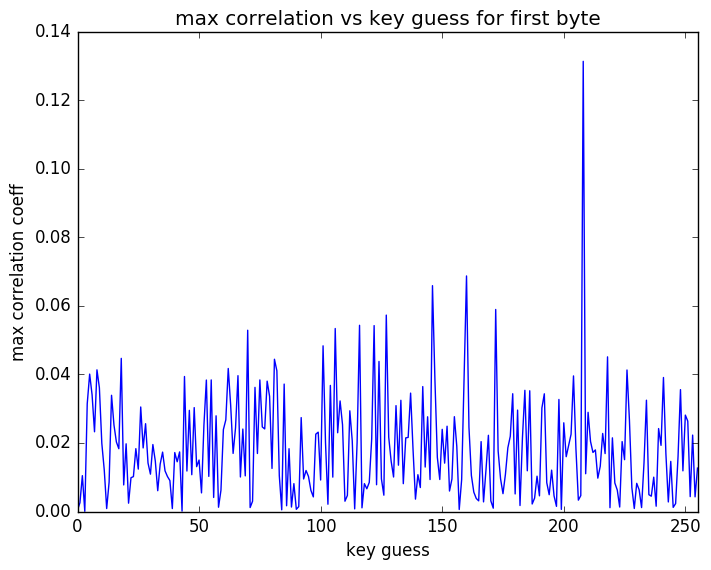

(0,255)

In [17]:
#plotting the variation of the maximas of different key guesses for the first byte
plt.plot(findmax(ρ[1,:,:],2)[1])
xlabel("key guess")
ylabel("max correlation coeff")
title("max correlation vs key guess for first byte")
plt.xlim(0,255)

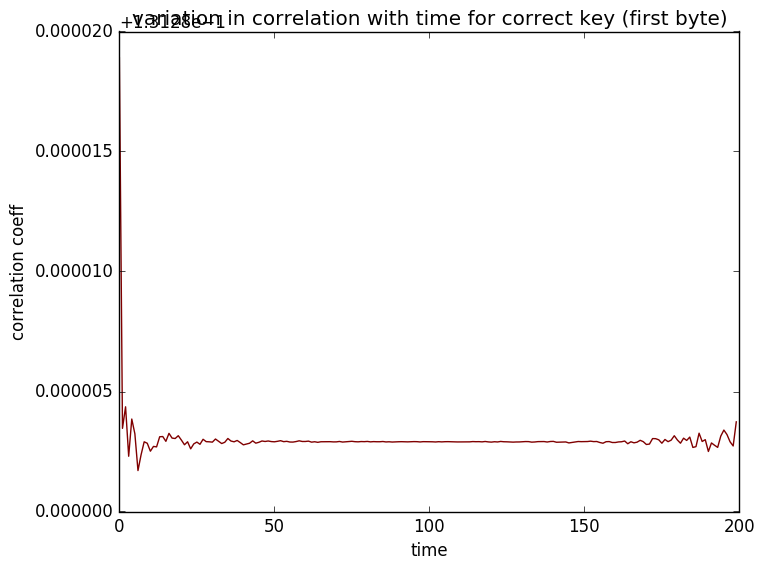

PyObject <matplotlib.text.Text object at 0x7f25d4fc18d0>

In [18]:
#plotting the variation for the correct key guess of the first byte (key = 208) with respect to time
plt.plot(ρ[1,209,:],color="maroon")
xlabel("time")
ylabel("correlation coeff")
title("variation in correlation with time for correct key (first byte)")

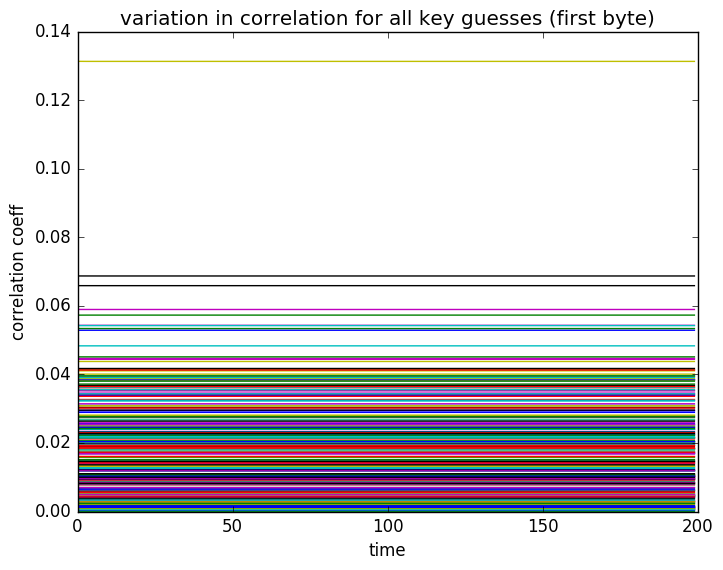

In [19]:
#plotting all the correlation variation with time for all key guess in the single graph for the first byte
for i in 1:256
    plt.plot(ρ[1,i,:])
    xlabel("time")
    ylabel("correlation coeff")
    title("variation in correlation for all key guesses (first byte)")
end

In [22]:
#function which takes interpretes ρ and finds out the key by joining all the maximums of every byte found
#note that this function is generic, no matter which round the attack is and what is the structure
#if ρ (can be formed for such a system) then key is always found using this method
function getkey_from_ρ(ρ)
    recovered_key = ""
    #trying to get the plots in array
    for byte_n in 1:16
        predict_k = findmax(findmax(ρ[byte_n,:,:],2)[1])[2]-1
        recovered_key = join([recovered_key,hex(predict_k,2)])
    end
    parse(UInt128,recovered_key,16)
end

getkey_from_ρ (generic function with 1 method)

In [23]:
getkey_from_ρ(ρ)
#reverse expansion can be done to get the original key

0xd0f7bf71c94cc08fe1dc3e91b6784d12

In [28]:
a = split("hg","a")

1-element Array{SubString{String},1}:
 "hg"